In [ ]:
'checkpoints_student/T=10, alpha=0.5, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001_pruning_0.1_final.tar'

In [31]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv
import sys
#sys.path.append('/content/KD')
# Import the module
import models
import utilities

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [33]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [4]:
import torchvision
import torchvision.transforms as transforms

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Path to the saved model
import utilities.model_utils


teacher_path = "../models/resnet50_cifar10_pretrained.bin"

# Initialize the network
teacher_net = models.teachers.TeacherNetworkR50()
teacher_net = teacher_net.to(fast_device)

# Load the checkpoint
checkpoint = torch.load(teacher_path)

# Load the state dictionary into the model
teacher_net.model.load_state_dict(checkpoint)

# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utilities.utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\daniel\AppData\Local\Temp\ipykernel_23460\1568890185.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.

test accuracy:  0.9224


In [34]:
from utilities.data_utils import load_data_CIFAR100

train_val_dataset, train_loader, val_loader, test_loader = load_data_CIFAR100()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from GPFQ.quantize_neural_net import QuantizeNeuralNet

# Path to the saved model
student_path = "..\model_checkpoints\checkpoints_student_mixup_cifar100\checkpoints_student_mixup_cifar100T=4, alpha=1.0, dropout_hidden=0.0, dropout_input=0.0, lr=0.0005, lr_decay=0.95, momentum=0.9, opt=adam, weight_decay=0.0001_epoch_200.tar"



# Initialize the network
student_model = models.student.StudentNetwork(dataset='cifar100')
student_model = student_model.to(fast_device)

# Load the checkpoint
student_model.load_model(student_path)

# Ensure reproducibility anda evaluate pre-trained teacher accuracy
reproducibilitySeed()


_, test_accuracy = utilities.utils.getLossAccuracyOnDataset(student_model, test_loader, fast_device)
print('Test accuracy:', test_accuracy)

pre_quantization = test_accuracy
post_quantization = []
bits = [2, 3, 4, 5, 6, 7, 8]
scalars = [.3, .5, .75, 1.0, 1.16, 1.16, 1.16]
for bit, scalar in zip(bits, scalars):

    quantizer = QuantizeNeuralNet(student_model.model,
        'resnet18',  # Default from `-model`
        batch_size=128,  # Default from `--batch_size`
        data_loader=train_loader,
        mlp_bits=bit,  # Default from `--bits`
        cnn_bits=bit,  # Default from `--bits`
        ignore_layers=[],  # Default from `--ignore_layer`
        mlp_alphabet_scalar=scalar,  # Default from `--scalar`
        cnn_alphabet_scalar=scalar,  # Default from `--scalar`
        mlp_percentile=1,  # Default from `--percentile`
        cnn_percentile=1,  # Default from `--percentile`
        reg=None,  # Default from `--regularizer`
        lamb=0.1,  # Default from `--lamb`
        retain_rate=0.25,  # Default from `--retain_rate`
        stochastic_quantization=False,  # Default from `--stochastic_quantization`
        device=fast_device
    )

    quantized_model = quantizer.quantize_network(verbose=False)

    _, test_accuracy = utilities.utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print('Test accuracy:', test_accuracy)
    post_quantization.append(test_accuracy)

c:\Users\daniel\dsc180b\DSC180B_Q2_Project\src\models\student.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path)


Test accuracy: 0.6217
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 2700.39it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2606.34it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3266.72it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3174.30it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2813.90it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3467.35it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3625.12it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1729.72it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2929.98it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2754.15it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3113.52it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3415.59it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2909.03it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3068.41it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3062.14it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3372.95it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3510.41it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2909.08it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3224.33it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3465.92it/s]


The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3436.22it/s]


Test accuracy: 0.2953
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 2250.30it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2249.98it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2294.67it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3154.32it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2826.82it/s]


The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2704.71it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2893.59it/s]


The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1684.21it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2773.71it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3085.13it/s]


The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2569.71it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3034.83it/s]


The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 3121.63it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3035.59it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2850.86it/s]


The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3073.27it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3120.91it/s]


The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3311.54it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2840.73it/s]


The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2818.84it/s]

In [9]:
print(post_quantization)
print(bits)
print(pre_quantization)

[0.521, 0.8923, 0.939, 0.9501, 0.954, 0.9554, 0.9553, 0.9555, 0.9542, 0.9568]
[2, 3, 4, 6, 8, 12, 16, 20, 26, 32]
0.9577


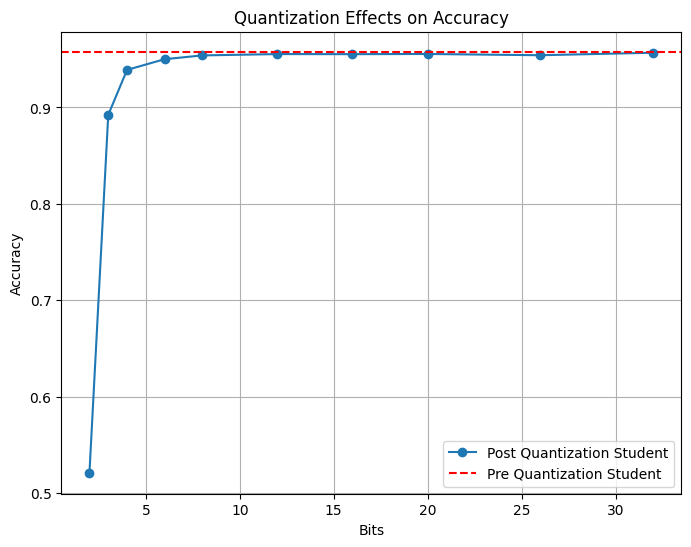

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(bits, post_quantization, marker='o', label='Post Quantization Student')
plt.axhline(pre_quantization, color='r', linestyle='--', label='Pre Quantization Student')
plt.xlabel('Bits')
plt.ylabel('Accuracy')
plt.title('Quantization Effects on Accuracy')
plt.legend()
plt.grid(True)

In [11]:
from GPFQ.quantize_neural_net import QuantizeNeuralNet

# Path to the saved model
teacher_path = "../models/resnet50_cifar10_pretrained.bin"



# Initialize the network
teacher_model = models.teachers.TeacherNetworkR50()

# Load the checkpoint
checkpoint = torch.load(teacher_path)

teacher_model.model.load_state_dict(checkpoint)
teacher_model.to(fast_device)
# Ensure reproducibility and evaluate pre-trained teacher accuracy
reproducibilitySeed()


_, test_accuracy = utilities.utils.getLossAccuracyOnDataset(teacher_model, test_loader, fast_device)
print('Test accuracy:', test_accuracy)

pre_quantization_teacher = test_accuracy
post_quantization_teacher = []
bits = [2, 3, 4, 6, 8, 12, 16, 20 , 26, 32]
scalars = [1.16, 1.16, 1.16, 1.16, 1.2, 1.5, 1.75, 1.75, 2, 2]

for bit in bits:

    quantizer = QuantizeNeuralNet(teacher_model.model,
        'resnet50',  # Default from `-model`
        batch_size=128,  # Default from `--batch_size`
        data_loader=train_loader,
        mlp_bits=bit,  # Default from `--bits`
        cnn_bits=bit,  # Default from `--bits`
        ignore_layers=[],  # Default from `--ignore_layer`
        mlp_alphabet_scalar=1.75,  # Default from `--scalar`
        cnn_alphabet_scalar=1.75,  # Default from `--scalar`
        mlp_percentile=1,  # Default from `--percentile`
        cnn_percentile=1,  # Default from `--percentile`
        reg=None,  # Default from `--regularizer`
        lamb=0.1,  # Default from `--lamb`
        retain_rate=0.25,  # Default from `--retain_rate`
        stochastic_quantization=False,  # Default from `--stochastic_quantization`
        device=fast_device
    )

    quantized_model = quantizer.quantize_network()

    _, test_accuracy = utilities.utils.getLossAccuracyOnDataset(quantized_model, test_loader, fast_device)
    print('Test accuracy:', test_accuracy)
    post_quantization_teacher.append(test_accuracy)

c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\daniel\anaconda3\envs\Classifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\daniel\AppData\Local\Temp\ipykernel_23460\4094146677.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.

Test accuracy: 0.9224
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 2076.85it/s]

The quantization error of layer 0 is 74.11003112792969.
The relative quantization error of layer 0 is 0.2481493353843689.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 665.58it/s]

The quantization error of layer 1 is 30.48805046081543.
The relative quantization error of layer 1 is 0.27406173944473267.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 1955.89it/s]


The quantization error of layer 2 is 12.592508316040039.
The relative quantization error of layer 2 is 0.2069534808397293.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1333.20it/s]

The quantization error of layer 3 is 28.077678680419922.
The relative quantization error of layer 3 is 0.3046037554740906.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1523.83it/s]

The quantization error of layer 4 is 43.353233337402344.
The relative quantization error of layer 4 is 0.26247304677963257.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2959.36it/s]

The quantization error of layer 5 is 27.53522491455078.
The relative quantization error of layer 5 is 0.2506777346134186.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2996.54it/s]


The quantization error of layer 6 is 8.97442626953125.
The relative quantization error of layer 6 is 0.208812415599823.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1488.28it/s]

The quantization error of layer 7 is 17.831024169921875.
The relative quantization error of layer 7 is 0.28705453872680664.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2737.75it/s]

The quantization error of layer 8 is 25.45488929748535.
The relative quantization error of layer 8 is 0.25917091965675354.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3235.69it/s]

The quantization error of layer 9 is 6.676239967346191.
The relative quantization error of layer 9 is 0.21219325065612793.




Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1280.00it/s]

The quantization error of layer 10 is 11.837770462036133.
The relative quantization error of layer 10 is 0.26026350259780884.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2152.34it/s]

The quantization error of layer 11 is 45.93547058105469.
The relative quantization error of layer 11 is 0.28615620732307434.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3347.22it/s]


The quantization error of layer 12 is 12.845423698425293.
The relative quantization error of layer 12 is 0.1967138648033142.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2145.48it/s]

The quantization error of layer 13 is 12.701203346252441.
The relative quantization error of layer 13 is 0.2579905688762665.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 652.97it/s]


The quantization error of layer 14 is 59.86075210571289.
The relative quantization error of layer 14 is 0.255230188369751.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3494.66it/s]

The quantization error of layer 15 is 14.305325508117676.
The relative quantization error of layer 15 is 0.24823148548603058.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3382.82it/s]


The quantization error of layer 16 is 4.106872081756592.
The relative quantization error of layer 16 is 0.18767300248146057.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2876.01it/s]

The quantization error of layer 17 is 7.712491512298584.
The relative quantization error of layer 17 is 0.2933909296989441.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3310.74it/s]

The quantization error of layer 18 is 16.635709762573242.
The relative quantization error of layer 18 is 0.277986079454422.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2940.62it/s]


The quantization error of layer 19 is 4.786623954772949.
The relative quantization error of layer 19 is 0.21033526957035065.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2204.47it/s]

The quantization error of layer 20 is 7.520784378051758.
The relative quantization error of layer 20 is 0.3664052486419678.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2765.45it/s]


The quantization error of layer 21 is 17.487836837768555.
The relative quantization error of layer 21 is 0.2979433834552765.


Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2662.91it/s]


The quantization error of layer 22 is 4.030618190765381.
The relative quantization error of layer 22 is 0.2541877329349518.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1815.34it/s]

The quantization error of layer 23 is 7.2668280601501465.
The relative quantization error of layer 23 is 0.4346737265586853.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2326.96it/s]


The quantization error of layer 24 is 31.078523635864258.
The relative quantization error of layer 24 is 0.3126140832901001.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2656.87it/s]


The quantization error of layer 25 is 8.450529098510742.
The relative quantization error of layer 25 is 0.202256441116333.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2767.25it/s]

The quantization error of layer 26 is 10.131390571594238.
The relative quantization error of layer 26 is 0.2647957503795624.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1429.24it/s]


The quantization error of layer 27 is 32.92232894897461.
The relative quantization error of layer 27 is 0.30125755071640015.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2923.75it/s]


The quantization error of layer 28 is 7.247596263885498.
The relative quantization error of layer 28 is 0.20214329659938812.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2925.51it/s]


The quantization error of layer 29 is 1.285961389541626.
The relative quantization error of layer 29 is 0.11528237164020538.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3065.43it/s]

The quantization error of layer 30 is 3.438997268676758.
The relative quantization error of layer 30 is 0.2611129581928253.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3068.18it/s]


The quantization error of layer 31 is 8.198534965515137.
The relative quantization error of layer 31 is 0.2360183745622635.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2958.09it/s]


The quantization error of layer 32 is 1.4611023664474487.
The relative quantization error of layer 32 is 0.11678618937730789.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3077.32it/s]

The quantization error of layer 33 is 3.9854369163513184.
The relative quantization error of layer 33 is 0.2998344898223877.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3188.28it/s]


The quantization error of layer 34 is 10.038933753967285.
The relative quantization error of layer 34 is 0.2595805823802948.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3033.49it/s]


The quantization error of layer 35 is 1.8183491230010986.
The relative quantization error of layer 35 is 0.14658506214618683.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2746.42it/s]

The quantization error of layer 36 is 4.941313743591309.
The relative quantization error of layer 36 is 0.40901193022727966.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3224.99it/s]


The quantization error of layer 37 is 11.64245891571045.
The relative quantization error of layer 37 is 0.3250269591808319.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3062.56it/s]


The quantization error of layer 38 is 2.141991376876831.
The relative quantization error of layer 38 is 0.16566568613052368.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2617.32it/s]

The quantization error of layer 39 is 4.741643905639648.
The relative quantization error of layer 39 is 0.48706623911857605.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3181.79it/s]


The quantization error of layer 40 is 11.43678092956543.
The relative quantization error of layer 40 is 0.3619230389595032.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3062.74it/s]


The quantization error of layer 41 is 2.014920473098755.
The relative quantization error of layer 41 is 0.16121970117092133.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2876.29it/s]

The quantization error of layer 42 is 4.434267044067383.
The relative quantization error of layer 42 is 0.4679773449897766.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3355.29it/s]


The quantization error of layer 43 is 15.021811485290527.
The relative quantization error of layer 43 is 0.3570869565010071.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3060.70it/s]


The quantization error of layer 44 is 1.7159205675125122.
The relative quantization error of layer 44 is 0.09338973462581635.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3129.64it/s]

The quantization error of layer 45 is 3.67549991607666.
The relative quantization error of layer 45 is 0.286063015460968.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2400.37it/s]


The quantization error of layer 46 is 8.191115379333496.
The relative quantization error of layer 46 is 0.38106080889701843.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3079.16it/s]


The quantization error of layer 47 is 9.499711990356445.
The relative quantization error of layer 47 is 0.239802747964859.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3132.19it/s]


The quantization error of layer 48 is 0.46628910303115845.
The relative quantization error of layer 48 is 0.08301526308059692.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3400.91it/s]

The quantization error of layer 49 is 1.259273886680603.
The relative quantization error of layer 49 is 0.28284287452697754.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3329.84it/s]


The quantization error of layer 50 is 14.099244117736816.
The relative quantization error of layer 50 is 0.23971286416053772.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2926.19it/s]


The quantization error of layer 51 is 0.37070655822753906.
The relative quantization error of layer 51 is 0.08041789382696152.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3140.14it/s]

The quantization error of layer 52 is 1.8899939060211182.
The relative quantization error of layer 52 is 0.32413315773010254.




Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2986.93it/s]


The quantization error of layer 53 is 20.666812896728516.
The relative quantization error of layer 53 is 0.14775396883487701.

Test accuracy: 0.9056
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 2454.72it/s]

The quantization error of layer 0 is 53.28987121582031.
The relative quantization error of layer 0 is 0.18378928303718567.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 794.92it/s]

The quantization error of layer 1 is 22.055042266845703.
The relative quantization error of layer 1 is 0.19803324341773987.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2503.54it/s]


The quantization error of layer 2 is 9.45603084564209.
The relative quantization error of layer 2 is 0.15577758848667145.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 649.70it/s]

The quantization error of layer 3 is 19.578693389892578.
The relative quantization error of layer 3 is 0.21241389214992523.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 852.39it/s]

The quantization error of layer 4 is 32.783077239990234.
The relative quantization error of layer 4 is 0.19932590425014496.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1907.40it/s]

The quantization error of layer 5 is 19.684370040893555.
The relative quantization error of layer 5 is 0.17894750833511353.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3280.20it/s]


The quantization error of layer 6 is 6.9969635009765625.
The relative quantization error of layer 6 is 0.16453392803668976.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 804.97it/s]


The quantization error of layer 7 is 12.406007766723633.
The relative quantization error of layer 7 is 0.20049768686294556.


Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1997.58it/s]

The quantization error of layer 8 is 18.187606811523438.
The relative quantization error of layer 8 is 0.18411001563072205.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3356.90it/s]

The quantization error of layer 9 is 4.844692707061768.
The relative quantization error of layer 9 is 0.1526748090982437.




Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 992.11it/s]

The quantization error of layer 10 is 8.606046676635742.
The relative quantization error of layer 10 is 0.18868523836135864.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1813.60it/s]

The quantization error of layer 11 is 30.577556610107422.
The relative quantization error of layer 11 is 0.19028034806251526.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3295.59it/s]


The quantization error of layer 12 is 9.339459419250488.
The relative quantization error of layer 12 is 0.1432972401380539.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2187.53it/s]

The quantization error of layer 13 is 8.422955513000488.
The relative quantization error of layer 13 is 0.17011809349060059.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 630.40it/s]


The quantization error of layer 14 is 40.7838020324707.
The relative quantization error of layer 14 is 0.17392753064632416.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3258.56it/s]

The quantization error of layer 15 is 9.717897415161133.
The relative quantization error of layer 15 is 0.16889286041259766.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3369.69it/s]


The quantization error of layer 16 is 2.7561545372009277.
The relative quantization error of layer 16 is 0.12561006844043732.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2875.77it/s]

The quantization error of layer 17 is 4.826333522796631.
The relative quantization error of layer 17 is 0.1818346530199051.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3249.58it/s]

The quantization error of layer 18 is 10.844599723815918.
The relative quantization error of layer 18 is 0.1819046288728714.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3040.37it/s]


The quantization error of layer 19 is 3.1175103187561035.
The relative quantization error of layer 19 is 0.1344020664691925.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2327.27it/s]

The quantization error of layer 20 is 4.723751544952393.
The relative quantization error of layer 20 is 0.22916661202907562.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3268.89it/s]

The quantization error of layer 21 is 11.139657020568848.
The relative quantization error of layer 21 is 0.19080527126789093.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3089.64it/s]


The quantization error of layer 22 is 2.5354604721069336.
The relative quantization error of layer 22 is 0.15984465181827545.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2081.10it/s]

The quantization error of layer 23 is 4.471603870391846.
The relative quantization error of layer 23 is 0.26582181453704834.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2694.62it/s]


The quantization error of layer 24 is 19.707849502563477.
The relative quantization error of layer 24 is 0.1993560791015625.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3338.20it/s]


The quantization error of layer 25 is 5.221998691558838.
The relative quantization error of layer 25 is 0.12849362194538116.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3179.30it/s]

The quantization error of layer 26 is 6.314764499664307.
The relative quantization error of layer 26 is 0.16625532507896423.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1499.15it/s]


The quantization error of layer 27 is 20.85296058654785.
The relative quantization error of layer 27 is 0.19132186472415924.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3340.67it/s]


The quantization error of layer 28 is 4.615111827850342.
The relative quantization error of layer 28 is 0.13088878989219666.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3077.48it/s]


The quantization error of layer 29 is 0.7739466428756714.
The relative quantization error of layer 29 is 0.06964211165904999.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3260.90it/s]

The quantization error of layer 30 is 2.1215133666992188.
The relative quantization error of layer 30 is 0.1611001342535019.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3300.01it/s]


The quantization error of layer 31 is 5.218148708343506.
The relative quantization error of layer 31 is 0.1531953513622284.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3256.62it/s]


The quantization error of layer 32 is 0.9295324087142944.
The relative quantization error of layer 32 is 0.07489795237779617.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2993.68it/s]

The quantization error of layer 33 is 2.454820156097412.
The relative quantization error of layer 33 is 0.18337221443653107.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3064.38it/s]


The quantization error of layer 34 is 6.199997901916504.
The relative quantization error of layer 34 is 0.1584966480731964.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2870.44it/s]


The quantization error of layer 35 is 1.0501136779785156.
The relative quantization error of layer 35 is 0.08481857925653458.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2595.12it/s]

The quantization error of layer 36 is 2.9514167308807373.
The relative quantization error of layer 36 is 0.24549752473831177.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2956.74it/s]


The quantization error of layer 37 is 7.207664966583252.
The relative quantization error of layer 37 is 0.19933173060417175.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2764.21it/s]


The quantization error of layer 38 is 1.1954716444015503.
The relative quantization error of layer 38 is 0.09412722289562225.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2797.42it/s]

The quantization error of layer 39 is 2.8825438022613525.
The relative quantization error of layer 39 is 0.30485841631889343.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3283.06it/s]


The quantization error of layer 40 is 7.004290580749512.
The relative quantization error of layer 40 is 0.21984408795833588.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2855.79it/s]


The quantization error of layer 41 is 1.1732568740844727.
The relative quantization error of layer 41 is 0.09345400333404541.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2794.97it/s]

The quantization error of layer 42 is 2.6787376403808594.
The relative quantization error of layer 42 is 0.2816206216812134.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2887.51it/s]


The quantization error of layer 43 is 8.98747444152832.
The relative quantization error of layer 43 is 0.21642276644706726.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2809.93it/s]


The quantization error of layer 44 is 1.086068034172058.
The relative quantization error of layer 44 is 0.05690750479698181.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2922.30it/s]

The quantization error of layer 45 is 2.176647186279297.
The relative quantization error of layer 45 is 0.16652342677116394.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2172.73it/s]


The quantization error of layer 46 is 5.153755187988281.
The relative quantization error of layer 46 is 0.23878569900989532.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3026.43it/s]


The quantization error of layer 47 is 6.1149210929870605.
The relative quantization error of layer 47 is 0.15015800297260284.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3186.48it/s]


The quantization error of layer 48 is 0.25343218445777893.
The relative quantization error of layer 48 is 0.04540970176458359.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3476.76it/s]

The quantization error of layer 49 is 0.9349060654640198.
The relative quantization error of layer 49 is 0.20913907885551453.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3201.31it/s]


The quantization error of layer 50 is 8.32650375366211.
The relative quantization error of layer 50 is 0.1425422579050064.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3182.83it/s]


The quantization error of layer 51 is 0.22162853181362152.
The relative quantization error of layer 51 is 0.04713050648570061.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2510.87it/s]


The quantization error of layer 52 is 1.1592273712158203.
The relative quantization error of layer 52 is 0.19973449409008026.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2741.01it/s]


The quantization error of layer 53 is 11.364396095275879.
The relative quantization error of layer 53 is 0.0798964574933052.

Test accuracy: 0.9171
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 1635.51it/s]

The quantization error of layer 0 is 45.213993072509766.
The relative quantization error of layer 0 is 0.1557631939649582.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 826.11it/s]

The quantization error of layer 1 is 21.101398468017578.
The relative quantization error of layer 1 is 0.18913137912750244.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2213.17it/s]


The quantization error of layer 2 is 8.409337997436523.
The relative quantization error of layer 2 is 0.13858851790428162.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1579.40it/s]

The quantization error of layer 3 is 16.88227653503418.
The relative quantization error of layer 3 is 0.18188680708408356.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1346.95it/s]

The quantization error of layer 4 is 29.30170249938965.
The relative quantization error of layer 4 is 0.17848794162273407.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3139.82it/s]

The quantization error of layer 5 is 17.053089141845703.
The relative quantization error of layer 5 is 0.15427275002002716.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3128.95it/s]


The quantization error of layer 6 is 6.235187530517578.
The relative quantization error of layer 6 is 0.1452006995677948.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1599.26it/s]

The quantization error of layer 7 is 10.355270385742188.
The relative quantization error of layer 7 is 0.1673346608877182.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2678.94it/s]

The quantization error of layer 8 is 14.337157249450684.
The relative quantization error of layer 8 is 0.14486677944660187.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3244.70it/s]


The quantization error of layer 9 is 4.001145839691162.
The relative quantization error of layer 9 is 0.1269097775220871.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1347.12it/s]

The quantization error of layer 10 is 7.387088298797607.
The relative quantization error of layer 10 is 0.16088685393333435.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2077.57it/s]

The quantization error of layer 11 is 24.12609100341797.
The relative quantization error of layer 11 is 0.1504107415676117.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3178.85it/s]


The quantization error of layer 12 is 7.996686935424805.
The relative quantization error of layer 12 is 0.12264300882816315.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2080.90it/s]

The quantization error of layer 13 is 6.703009605407715.
The relative quantization error of layer 13 is 0.13550104200839996.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 645.96it/s]


The quantization error of layer 14 is 32.508792877197266.
The relative quantization error of layer 14 is 0.13838079571723938.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3026.02it/s]

The quantization error of layer 15 is 7.689265727996826.
The relative quantization error of layer 15 is 0.1331324279308319.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3337.22it/s]


The quantization error of layer 16 is 2.1433417797088623.
The relative quantization error of layer 16 is 0.09887000173330307.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2842.98it/s]

The quantization error of layer 17 is 3.6230990886688232.
The relative quantization error of layer 17 is 0.13602715730667114.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3248.49it/s]

The quantization error of layer 18 is 8.49682331085205.
The relative quantization error of layer 18 is 0.14250463247299194.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3062.95it/s]


The quantization error of layer 19 is 2.5052647590637207.
The relative quantization error of layer 19 is 0.10814479738473892.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2156.87it/s]

The quantization error of layer 20 is 3.484872341156006.
The relative quantization error of layer 20 is 0.1683470457792282.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3592.61it/s]

The quantization error of layer 21 is 8.493677139282227.
The relative quantization error of layer 21 is 0.14436417818069458.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3170.73it/s]


The quantization error of layer 22 is 1.8511509895324707.
The relative quantization error of layer 22 is 0.11757323145866394.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2098.26it/s]

The quantization error of layer 23 is 3.0816571712493896.
The relative quantization error of layer 23 is 0.18439775705337524.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2826.04it/s]

The quantization error of layer 24 is 14.63930892944336.


The relative quantization error of layer 24 is 0.1481909304857254.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3336.43it/s]


The quantization error of layer 25 is 3.996453046798706.
The relative quantization error of layer 25 is 0.09524468332529068.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2828.40it/s]

The quantization error of layer 26 is 4.494654655456543.
The relative quantization error of layer 26 is 0.11694172024726868.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1473.03it/s]


The quantization error of layer 27 is 15.695101737976074.
The relative quantization error of layer 27 is 0.14439602196216583.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3327.78it/s]


The quantization error of layer 28 is 3.6360039710998535.
The relative quantization error of layer 28 is 0.10292061418294907.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2882.77it/s]


The quantization error of layer 29 is 0.5666192173957825.
The relative quantization error of layer 29 is 0.05047508701682091.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2777.86it/s]

The quantization error of layer 30 is 1.5069223642349243.
The relative quantization error of layer 30 is 0.11443335562944412.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3273.10it/s]


The quantization error of layer 31 is 3.8118155002593994.
The relative quantization error of layer 31 is 0.11084859818220139.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2805.18it/s]


The quantization error of layer 32 is 0.6346153616905212.
The relative quantization error of layer 32 is 0.05174653232097626.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2971.50it/s]

The quantization error of layer 33 is 1.780297040939331.
The relative quantization error of layer 33 is 0.1331525593996048.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3169.37it/s]


The quantization error of layer 34 is 4.478143215179443.
The relative quantization error of layer 34 is 0.11328692734241486.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2993.28it/s]


The quantization error of layer 35 is 0.6840046048164368.
The relative quantization error of layer 35 is 0.05455232039093971.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2708.66it/s]

The quantization error of layer 36 is 1.9400510787963867.
The relative quantization error of layer 36 is 0.16315419971942902.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3307.99it/s]


The quantization error of layer 37 is 4.814176559448242.
The relative quantization error of layer 37 is 0.13497880101203918.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2849.07it/s]


The quantization error of layer 38 is 0.7672834396362305.
The relative quantization error of layer 38 is 0.059389423578977585.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2680.49it/s]

The quantization error of layer 39 is 1.849937915802002.
The relative quantization error of layer 39 is 0.19725745916366577.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2974.97it/s]


The quantization error of layer 40 is 4.515238285064697.
The relative quantization error of layer 40 is 0.1425986886024475.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2965.88it/s]


The quantization error of layer 41 is 0.7359529137611389.
The relative quantization error of layer 41 is 0.05864468216896057.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2680.34it/s]

The quantization error of layer 42 is 1.8133134841918945.
The relative quantization error of layer 42 is 0.19161169230937958.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3078.62it/s]


The quantization error of layer 43 is 6.042203426361084.
The relative quantization error of layer 43 is 0.14381855726242065.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2983.75it/s]


The quantization error of layer 44 is 0.7273849248886108.
The relative quantization error of layer 44 is 0.03789850324392319.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2941.83it/s]

The quantization error of layer 45 is 1.7392666339874268.
The relative quantization error of layer 45 is 0.13604237139225006.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2442.13it/s]


The quantization error of layer 46 is 3.8093273639678955.
The relative quantization error of layer 46 is 0.17647238075733185.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3233.12it/s]


The quantization error of layer 47 is 4.612452507019043.
The relative quantization error of layer 47 is 0.11206362396478653.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3246.78it/s]


The quantization error of layer 48 is 0.1848391890525818.
The relative quantization error of layer 48 is 0.03342461213469505.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3408.82it/s]

The quantization error of layer 49 is 0.8281629085540771.
The relative quantization error of layer 49 is 0.18263459205627441.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3165.68it/s]


The quantization error of layer 50 is 6.4843831062316895.
The relative quantization error of layer 50 is 0.10943789780139923.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3070.65it/s]


The quantization error of layer 51 is 0.17179515957832336.
The relative quantization error of layer 51 is 0.036467816680669785.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2952.76it/s]


The quantization error of layer 52 is 1.0295003652572632.
The relative quantization error of layer 52 is 0.17444895207881927.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2886.94it/s]


The quantization error of layer 53 is 8.400235176086426.
The relative quantization error of layer 53 is 0.05999179184436798.

Test accuracy: 0.9195
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 2247.26it/s]

The quantization error of layer 0 is 43.31279373168945.
The relative quantization error of layer 0 is 0.14741742610931396.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 870.65it/s]

The quantization error of layer 1 is 19.644968032836914.
The relative quantization error of layer 1 is 0.1768406629562378.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2318.09it/s]


The quantization error of layer 2 is 8.02581787109375.
The relative quantization error of layer 2 is 0.1322920173406601.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 607.86it/s]

The quantization error of layer 3 is 16.316978454589844.
The relative quantization error of layer 3 is 0.1758018583059311.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 779.47it/s]

The quantization error of layer 4 is 27.532045364379883.
The relative quantization error of layer 4 is 0.16731852293014526.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1880.54it/s]

The quantization error of layer 5 is 16.518325805664062.
The relative quantization error of layer 5 is 0.14848099648952484.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3078.79it/s]


The quantization error of layer 6 is 6.183706760406494.
The relative quantization error of layer 6 is 0.14485344290733337.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 966.52it/s]

The quantization error of layer 7 is 9.693184852600098.
The relative quantization error of layer 7 is 0.15628699958324432.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2325.38it/s]

The quantization error of layer 8 is 13.854132652282715.
The relative quantization error of layer 8 is 0.14188677072525024.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3432.20it/s]

The quantization error of layer 9 is 3.926997423171997.
The relative quantization error of layer 9 is 0.12591418623924255.




Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1015.83it/s]

The quantization error of layer 10 is 7.038034439086914.
The relative quantization error of layer 10 is 0.15326690673828125.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1867.91it/s]

The quantization error of layer 11 is 21.90496063232422.
The relative quantization error of layer 11 is 0.1368451714515686.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3375.69it/s]


The quantization error of layer 12 is 7.878822326660156.
The relative quantization error of layer 12 is 0.11997240036725998.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2245.55it/s]

The quantization error of layer 13 is 6.289581775665283.
The relative quantization error of layer 13 is 0.12726719677448273.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 652.07it/s]


The quantization error of layer 14 is 30.57709312438965.
The relative quantization error of layer 14 is 0.1298835724592209.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3498.98it/s]

The quantization error of layer 15 is 7.206343650817871.
The relative quantization error of layer 15 is 0.12451983243227005.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3419.60it/s]


The quantization error of layer 16 is 1.8670856952667236.
The relative quantization error of layer 16 is 0.08496449142694473.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2481.37it/s]

The quantization error of layer 17 is 3.099578380584717.
The relative quantization error of layer 17 is 0.1159813404083252.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3475.33it/s]

The quantization error of layer 18 is 7.880301475524902.
The relative quantization error of layer 18 is 0.13228920102119446.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3346.45it/s]


The quantization error of layer 19 is 2.2851996421813965.
The relative quantization error of layer 19 is 0.09965427964925766.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2285.62it/s]

The quantization error of layer 20 is 2.982347249984741.
The relative quantization error of layer 20 is 0.14543399214744568.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3225.53it/s]

The quantization error of layer 21 is 7.812440395355225.
The relative quantization error of layer 21 is 0.1328737437725067.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3013.34it/s]


The quantization error of layer 22 is 1.5887110233306885.
The relative quantization error of layer 22 is 0.09995626658201218.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2369.97it/s]

The quantization error of layer 23 is 2.475680351257324.
The relative quantization error of layer 23 is 0.14760246872901917.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3004.99it/s]

The quantization error of layer 24 is 12.205183029174805.
The relative quantization error of layer 24 is 0.1235702857375145.




Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3488.29it/s]


The quantization error of layer 25 is 3.5135908126831055.
The relative quantization error of layer 25 is 0.08585236966609955.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3212.91it/s]

The quantization error of layer 26 is 3.789044141769409.
The relative quantization error of layer 26 is 0.09808842837810516.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1528.50it/s]


The quantization error of layer 27 is 13.416163444519043.
The relative quantization error of layer 27 is 0.1225460022687912.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3228.08it/s]


The quantization error of layer 28 is 3.2691378593444824.
The relative quantization error of layer 28 is 0.0931825190782547.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3296.58it/s]


The quantization error of layer 29 is 0.5055269002914429.
The relative quantization error of layer 29 is 0.04559134319424629.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3140.76it/s]

The quantization error of layer 30 is 1.2986974716186523.
The relative quantization error of layer 30 is 0.09833866357803345.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3373.65it/s]


The quantization error of layer 31 is 3.343327522277832.
The relative quantization error of layer 31 is 0.09763228893280029.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3147.30it/s]


The quantization error of layer 32 is 0.5571795105934143.
The relative quantization error of layer 32 is 0.04407292231917381.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3236.01it/s]

The quantization error of layer 33 is 1.4559910297393799.
The relative quantization error of layer 33 is 0.1094135269522667.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3237.70it/s]


The quantization error of layer 34 is 3.661789894104004.
The relative quantization error of layer 34 is 0.09455316513776779.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3140.23it/s]


The quantization error of layer 35 is 0.5136696100234985.
The relative quantization error of layer 35 is 0.04180783033370972.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3270.15it/s]

The quantization error of layer 36 is 1.514395833015442.
The relative quantization error of layer 36 is 0.12377386540174484.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3458.09it/s]


The quantization error of layer 37 is 3.9048495292663574.
The relative quantization error of layer 37 is 0.10779532045125961.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3202.14it/s]


The quantization error of layer 38 is 0.5969430208206177.
The relative quantization error of layer 38 is 0.045608989894390106.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3413.21it/s]

The quantization error of layer 39 is 1.4173275232315063.
The relative quantization error of layer 39 is 0.1496782749891281.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3358.59it/s]


The quantization error of layer 40 is 3.562838554382324.
The relative quantization error of layer 40 is 0.11266236752271652.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3124.03it/s]


The quantization error of layer 41 is 0.5333070158958435.
The relative quantization error of layer 41 is 0.041117340326309204.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3367.60it/s]

The quantization error of layer 42 is 1.4437280893325806.
The relative quantization error of layer 42 is 0.14795555174350739.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3534.75it/s]


The quantization error of layer 43 is 4.811976909637451.
The relative quantization error of layer 43 is 0.11600850522518158.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3242.15it/s]


The quantization error of layer 44 is 0.5752173066139221.
The relative quantization error of layer 44 is 0.031025681644678116.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3362.67it/s]

The quantization error of layer 45 is 1.555780053138733.
The relative quantization error of layer 45 is 0.11857389658689499.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2808.11it/s]


The quantization error of layer 46 is 3.1685965061187744.
The relative quantization error of layer 46 is 0.14379262924194336.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3308.17it/s]


The quantization error of layer 47 is 4.359099864959717.
The relative quantization error of layer 47 is 0.11059391498565674.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3250.50it/s]


The quantization error of layer 48 is 0.15954230725765228.
The relative quantization error of layer 48 is 0.028170889243483543.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3354.24it/s]

The quantization error of layer 49 is 0.797691822052002.
The relative quantization error of layer 49 is 0.176924467086792.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3330.19it/s]


The quantization error of layer 50 is 5.742511749267578.
The relative quantization error of layer 50 is 0.10136009007692337.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3225.15it/s]


The quantization error of layer 51 is 0.16601380705833435.
The relative quantization error of layer 51 is 0.03485720977187157.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3368.91it/s]

The quantization error of layer 52 is 0.9570215940475464.
The relative quantization error of layer 52 is 0.16434790194034576.




Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3124.41it/s]


The quantization error of layer 53 is 7.499504089355469.
The relative quantization error of layer 53 is 0.053991708904504776.

Test accuracy: 0.9197
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 1928.42it/s]

The quantization error of layer 0 is 42.71966552734375.
The relative quantization error of layer 0 is 0.14805634319782257.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 589.30it/s]

The quantization error of layer 1 is 19.06090545654297.
The relative quantization error of layer 1 is 0.1706867218017578.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2522.11it/s]


The quantization error of layer 2 is 8.16565990447998.
The relative quantization error of layer 2 is 0.13275404274463654.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 187.97it/s]


The quantization error of layer 3 is 15.793323516845703.
The relative quantization error of layer 3 is 0.17225731909275055.


Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1619.89it/s]

The quantization error of layer 4 is 27.507246017456055.
The relative quantization error of layer 4 is 0.1666397899389267.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2383.71it/s]

The quantization error of layer 5 is 16.216123580932617.
The relative quantization error of layer 5 is 0.14688411355018616.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3046.87it/s]


The quantization error of layer 6 is 6.043956756591797.
The relative quantization error of layer 6 is 0.1408924013376236.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1515.75it/s]

The quantization error of layer 7 is 9.745504379272461.
The relative quantization error of layer 7 is 0.15632715821266174.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3157.97it/s]

The quantization error of layer 8 is 14.056285858154297.
The relative quantization error of layer 8 is 0.14164075255393982.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3233.03it/s]


The quantization error of layer 9 is 3.9059178829193115.
The relative quantization error of layer 9 is 0.12402620911598206.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 955.15it/s]

The quantization error of layer 10 is 6.958802700042725.
The relative quantization error of layer 10 is 0.1519087702035904.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2113.33it/s]

The quantization error of layer 11 is 21.743122100830078.
The relative quantization error of layer 11 is 0.13565579056739807.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3322.85it/s]


The quantization error of layer 12 is 7.670063018798828.
The relative quantization error of layer 12 is 0.11797545105218887.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2241.72it/s]

The quantization error of layer 13 is 5.970808029174805.
The relative quantization error of layer 13 is 0.12011104077100754.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 682.58it/s]


The quantization error of layer 14 is 29.325138092041016.
The relative quantization error of layer 14 is 0.12511953711509705.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3054.45it/s]

The quantization error of layer 15 is 7.1244425773620605.
The relative quantization error of layer 15 is 0.12355364859104156.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3273.31it/s]


The quantization error of layer 16 is 1.8714951276779175.
The relative quantization error of layer 16 is 0.08553069084882736.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2685.27it/s]

The quantization error of layer 17 is 3.056159257888794.
The relative quantization error of layer 17 is 0.11555691063404083.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3506.06it/s]

The quantization error of layer 18 is 7.439302444458008.
The relative quantization error of layer 18 is 0.12442108988761902.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3339.23it/s]


The quantization error of layer 19 is 2.2841272354125977.
The relative quantization error of layer 19 is 0.09767826646566391.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2437.74it/s]

The quantization error of layer 20 is 2.9423394203186035.
The relative quantization error of layer 20 is 0.14300328493118286.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3447.44it/s]

The quantization error of layer 21 is 7.705671787261963.
The relative quantization error of layer 21 is 0.1315036565065384.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3110.06it/s]


The quantization error of layer 22 is 1.551530361175537.
The relative quantization error of layer 22 is 0.09844392538070679.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2187.41it/s]

The quantization error of layer 23 is 2.4728713035583496.
The relative quantization error of layer 23 is 0.14665865898132324.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2826.78it/s]


The quantization error of layer 24 is 12.088680267333984.
The relative quantization error of layer 24 is 0.12228492647409439.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3306.42it/s]


The quantization error of layer 25 is 3.475782632827759.
The relative quantization error of layer 25 is 0.08521626144647598.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3151.20it/s]

The quantization error of layer 26 is 3.6358354091644287.
The relative quantization error of layer 26 is 0.09390349686145782.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1547.77it/s]


The quantization error of layer 27 is 13.175459861755371.
The relative quantization error of layer 27 is 0.12055257707834244.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3192.95it/s]


The quantization error of layer 28 is 3.3447186946868896.
The relative quantization error of layer 28 is 0.09533967077732086.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3147.17it/s]


The quantization error of layer 29 is 0.5317807197570801.
The relative quantization error of layer 29 is 0.04719237983226776.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2222.42it/s]

The quantization error of layer 30 is 1.3219484090805054.
The relative quantization error of layer 30 is 0.09873534739017487.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3115.46it/s]


The quantization error of layer 31 is 3.3187637329101562.
The relative quantization error of layer 31 is 0.09625893086194992.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3145.83it/s]


The quantization error of layer 32 is 0.540550172328949.
The relative quantization error of layer 32 is 0.04343191161751747.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3029.30it/s]

The quantization error of layer 33 is 1.4501559734344482.
The relative quantization error of layer 33 is 0.10977821052074432.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3318.19it/s]


The quantization error of layer 34 is 3.748537063598633.
The relative quantization error of layer 34 is 0.0955670028924942.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3184.30it/s]


The quantization error of layer 35 is 0.48794519901275635.
The relative quantization error of layer 35 is 0.03889242932200432.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2813.11it/s]

The quantization error of layer 36 is 1.4849191904067993.
The relative quantization error of layer 36 is 0.12286675721406937.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3110.56it/s]


The quantization error of layer 37 is 3.782719612121582.
The relative quantization error of layer 37 is 0.105364128947258.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3029.36it/s]


The quantization error of layer 38 is 0.5155191421508789.
The relative quantization error of layer 38 is 0.040309906005859375.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2693.42it/s]

The quantization error of layer 39 is 1.3977233171463013.
The relative quantization error of layer 39 is 0.15050429105758667.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3232.18it/s]


The quantization error of layer 40 is 3.441890239715576.
The relative quantization error of layer 40 is 0.1097654476761818.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2862.34it/s]


The quantization error of layer 41 is 0.5119075775146484.
The relative quantization error of layer 41 is 0.04158853739500046.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2458.43it/s]

The quantization error of layer 42 is 1.397707462310791.
The relative quantization error of layer 42 is 0.14843830466270447.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2936.45it/s]


The quantization error of layer 43 is 4.449901580810547.
The relative quantization error of layer 43 is 0.1065330058336258.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3045.91it/s]


The quantization error of layer 44 is 0.5735602378845215.
The relative quantization error of layer 44 is 0.030003249645233154.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3035.56it/s]

The quantization error of layer 45 is 1.4688942432403564.
The relative quantization error of layer 45 is 0.11495118588209152.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2441.97it/s]


The quantization error of layer 46 is 3.1606316566467285.
The relative quantization error of layer 46 is 0.14535430073738098.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3313.56it/s]


The quantization error of layer 47 is 4.0760273933410645.
The relative quantization error of layer 47 is 0.10065959393978119.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3268.93it/s]


The quantization error of layer 48 is 0.15947158634662628.
The relative quantization error of layer 48 is 0.028267813846468925.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3311.88it/s]

The quantization error of layer 49 is 0.8134024739265442.
The relative quantization error of layer 49 is 0.18243034183979034.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3062.40it/s]


The quantization error of layer 50 is 6.167665958404541.
The relative quantization error of layer 50 is 0.1031554564833641.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3010.23it/s]


The quantization error of layer 51 is 0.1593717336654663.
The relative quantization error of layer 51 is 0.03217720985412598.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2925.36it/s]


The quantization error of layer 52 is 0.9019047021865845.
The relative quantization error of layer 52 is 0.15668097138404846.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2982.13it/s]


The quantization error of layer 53 is 7.365747928619385.
The relative quantization error of layer 53 is 0.052428003400564194.

Test accuracy: 0.9195
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 1799.90it/s]

The quantization error of layer 0 is 41.67372512817383.
The relative quantization error of layer 0 is 0.1436728835105896.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 870.64it/s]

The quantization error of layer 1 is 18.744873046875.
The relative quantization error of layer 1 is 0.16806259751319885.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2288.31it/s]


The quantization error of layer 2 is 7.597098350524902.
The relative quantization error of layer 2 is 0.1253650039434433.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 591.83it/s]

The quantization error of layer 3 is 16.025564193725586.
The relative quantization error of layer 3 is 0.173434779047966.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 739.83it/s]

The quantization error of layer 4 is 26.985639572143555.
The relative quantization error of layer 4 is 0.1641560047864914.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1745.81it/s]

The quantization error of layer 5 is 16.631725311279297.
The relative quantization error of layer 5 is 0.15086932480335236.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3441.64it/s]

The quantization error of layer 6 is 6.174348831176758.
The relative quantization error of layer 6 is 0.1433957815170288.




Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1042.31it/s]

The quantization error of layer 7 is 9.8018217086792.
The relative quantization error of layer 7 is 0.15722496807575226.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2334.81it/s]

The quantization error of layer 8 is 14.232416152954102.
The relative quantization error of layer 8 is 0.1437041461467743.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3045.10it/s]


The quantization error of layer 9 is 4.030486583709717.
The relative quantization error of layer 9 is 0.12773552536964417.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 954.89it/s]

The quantization error of layer 10 is 7.028641223907471.
The relative quantization error of layer 10 is 0.15166234970092773.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1554.18it/s]

The quantization error of layer 11 is 21.973072052001953.
The relative quantization error of layer 11 is 0.136973038315773.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3436.44it/s]


The quantization error of layer 12 is 7.989681720733643.
The relative quantization error of layer 12 is 0.12176358699798584.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2390.64it/s]

The quantization error of layer 13 is 6.088356018066406.
The relative quantization error of layer 13 is 0.12323291599750519.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 643.84it/s]


The quantization error of layer 14 is 29.931568145751953.
The relative quantization error of layer 14 is 0.12789775431156158.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3179.95it/s]

The quantization error of layer 15 is 7.13428258895874.
The relative quantization error of layer 15 is 0.12294823676347733.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3211.23it/s]


The quantization error of layer 16 is 1.9610410928726196.
The relative quantization error of layer 16 is 0.08973975479602814.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2301.69it/s]

The quantization error of layer 17 is 3.029764413833618.
The relative quantization error of layer 17 is 0.11513183265924454.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3158.17it/s]

The quantization error of layer 18 is 7.625995635986328.
The relative quantization error of layer 18 is 0.12736397981643677.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3109.24it/s]


The quantization error of layer 19 is 2.2288427352905273.
The relative quantization error of layer 19 is 0.09679822623729706.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2224.87it/s]

The quantization error of layer 20 is 2.988516330718994.
The relative quantization error of layer 20 is 0.14495046436786652.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3257.56it/s]

The quantization error of layer 21 is 7.524496078491211.
The relative quantization error of layer 21 is 0.12814012169837952.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3167.42it/s]


The quantization error of layer 22 is 1.6288871765136719.
The relative quantization error of layer 22 is 0.10131433606147766.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2415.07it/s]

The quantization error of layer 23 is 2.3887391090393066.
The relative quantization error of layer 23 is 0.14237922430038452.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2808.53it/s]


The quantization error of layer 24 is 11.998409271240234.
The relative quantization error of layer 24 is 0.12133531272411346.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3188.73it/s]


The quantization error of layer 25 is 3.3162684440612793.
The relative quantization error of layer 25 is 0.08086936920881271.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2842.93it/s]

The quantization error of layer 26 is 3.7440760135650635.
The relative quantization error of layer 26 is 0.09704805165529251.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1480.91it/s]


The quantization error of layer 27 is 13.337142944335938.
The relative quantization error of layer 27 is 0.12208902835845947.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3267.50it/s]


The quantization error of layer 28 is 3.3144373893737793.
The relative quantization error of layer 28 is 0.09336352348327637.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3086.29it/s]


The quantization error of layer 29 is 0.5220819711685181.
The relative quantization error of layer 29 is 0.04616327956318855.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3301.93it/s]

The quantization error of layer 30 is 1.3122270107269287.
The relative quantization error of layer 30 is 0.09992518275976181.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3077.80it/s]


The quantization error of layer 31 is 3.4038503170013428.
The relative quantization error of layer 31 is 0.10052657872438431.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3075.46it/s]


The quantization error of layer 32 is 0.5685753226280212.
The relative quantization error of layer 32 is 0.045746468007564545.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2518.89it/s]

The quantization error of layer 33 is 1.4394302368164062.
The relative quantization error of layer 33 is 0.1095307320356369.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2882.65it/s]


The quantization error of layer 34 is 3.743413209915161.
The relative quantization error of layer 34 is 0.09696128964424133.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3011.92it/s]


The quantization error of layer 35 is 0.5042783617973328.
The relative quantization error of layer 35 is 0.04064397141337395.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2990.72it/s]

The quantization error of layer 36 is 1.4935742616653442.
The relative quantization error of layer 36 is 0.1236235573887825.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2927.40it/s]


The quantization error of layer 37 is 3.7998299598693848.
The relative quantization error of layer 37 is 0.1041913777589798.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3153.32it/s]


The quantization error of layer 38 is 0.5259150266647339.
The relative quantization error of layer 38 is 0.040005192160606384.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2680.33it/s]

The quantization error of layer 39 is 1.3695158958435059.
The relative quantization error of layer 39 is 0.14754459261894226.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2962.60it/s]


The quantization error of layer 40 is 3.5311710834503174.
The relative quantization error of layer 40 is 0.11140839755535126.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3032.27it/s]


The quantization error of layer 41 is 0.5126497149467468.
The relative quantization error of layer 41 is 0.04047907888889313.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2826.16it/s]

The quantization error of layer 42 is 1.3851900100708008.
The relative quantization error of layer 42 is 0.14683598279953003.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3097.10it/s]


The quantization error of layer 43 is 4.625594139099121.
The relative quantization error of layer 43 is 0.11140096187591553.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3047.81it/s]


The quantization error of layer 44 is 0.5262105464935303.
The relative quantization error of layer 44 is 0.02875661849975586.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3100.01it/s]

The quantization error of layer 45 is 1.4713538885116577.
The relative quantization error of layer 45 is 0.11253442615270615.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2179.47it/s]


The quantization error of layer 46 is 3.099952220916748.
The relative quantization error of layer 46 is 0.1427503228187561.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3160.66it/s]


The quantization error of layer 47 is 4.057321071624756.
The relative quantization error of layer 47 is 0.10151433944702148.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3027.90it/s]


The quantization error of layer 48 is 0.16714495420455933.
The relative quantization error of layer 48 is 0.029589351266622543.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3195.86it/s]

The quantization error of layer 49 is 0.8137969970703125.
The relative quantization error of layer 49 is 0.1808074712753296.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3103.43it/s]


The quantization error of layer 50 is 6.312140941619873.
The relative quantization error of layer 50 is 0.10775072127580643.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2931.31it/s]


The quantization error of layer 51 is 0.16401179134845734.
The relative quantization error of layer 51 is 0.03367556631565094.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3111.12it/s]

The quantization error of layer 52 is 0.9460256695747375.
The relative quantization error of layer 52 is 0.16226983070373535.




Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2848.47it/s]


The quantization error of layer 53 is 7.027889728546143.
The relative quantization error of layer 53 is 0.0494123138487339.

Test accuracy: 0.9194
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 1227.48it/s]


The quantization error of layer 0 is 43.18962097167969.
The relative quantization error of layer 0 is 0.15045958757400513.


Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 757.14it/s]

The quantization error of layer 1 is 19.365877151489258.
The relative quantization error of layer 1 is 0.17422352731227875.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2439.28it/s]


The quantization error of layer 2 is 8.139887809753418.
The relative quantization error of layer 2 is 0.13514497876167297.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 703.19it/s]

The quantization error of layer 3 is 15.794877052307129.
The relative quantization error of layer 3 is 0.17166349291801453.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1022.56it/s]

The quantization error of layer 4 is 27.298768997192383.
The relative quantization error of layer 4 is 0.1661035120487213.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2284.80it/s]

The quantization error of layer 5 is 15.960443496704102.
The relative quantization error of layer 5 is 0.14660844206809998.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3028.02it/s]


The quantization error of layer 6 is 5.956521034240723.
The relative quantization error of layer 6 is 0.1394544243812561.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1006.31it/s]

The quantization error of layer 7 is 9.614999771118164.
The relative quantization error of layer 7 is 0.15443533658981323.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2043.94it/s]

The quantization error of layer 8 is 13.834009170532227.
The relative quantization error of layer 8 is 0.14067044854164124.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2821.28it/s]


The quantization error of layer 9 is 3.9519643783569336.
The relative quantization error of layer 9 is 0.12701545655727386.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1110.13it/s]

The quantization error of layer 10 is 7.0485405921936035.
The relative quantization error of layer 10 is 0.154655322432518.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1841.57it/s]

The quantization error of layer 11 is 22.17229652404785.
The relative quantization error of layer 11 is 0.13776913285255432.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3094.38it/s]


The quantization error of layer 12 is 7.89931583404541.
The relative quantization error of layer 12 is 0.12156666070222855.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2057.98it/s]

The quantization error of layer 13 is 6.128918647766113.
The relative quantization error of layer 13 is 0.12350688129663467.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 630.18it/s]


The quantization error of layer 14 is 29.79649543762207.
The relative quantization error of layer 14 is 0.12618373334407806.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3158.60it/s]

The quantization error of layer 15 is 7.145776748657227.
The relative quantization error of layer 15 is 0.12275820970535278.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3108.51it/s]


The quantization error of layer 16 is 1.8619427680969238.
The relative quantization error of layer 16 is 0.08467908948659897.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2508.44it/s]

The quantization error of layer 17 is 3.0045433044433594.
The relative quantization error of layer 17 is 0.11331944912672043.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3334.65it/s]

The quantization error of layer 18 is 7.641871929168701.
The relative quantization error of layer 18 is 0.12861742079257965.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2835.41it/s]


The quantization error of layer 19 is 2.2669858932495117.
The relative quantization error of layer 19 is 0.09878014773130417.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2133.30it/s]

The quantization error of layer 20 is 3.0221002101898193.
The relative quantization error of layer 20 is 0.146857351064682.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3355.81it/s]

The quantization error of layer 21 is 7.723292827606201.
The relative quantization error of layer 21 is 0.13206441700458527.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3151.29it/s]


The quantization error of layer 22 is 1.5879501104354858.
The relative quantization error of layer 22 is 0.10011767596006393.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2278.17it/s]

The quantization error of layer 23 is 2.428445816040039.
The relative quantization error of layer 23 is 0.14317317306995392.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2869.72it/s]


The quantization error of layer 24 is 12.19491958618164.
The relative quantization error of layer 24 is 0.1229715570807457.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3355.87it/s]


The quantization error of layer 25 is 3.6253793239593506.
The relative quantization error of layer 25 is 0.08748006820678711.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2955.18it/s]

The quantization error of layer 26 is 3.7457447052001953.
The relative quantization error of layer 26 is 0.09776939451694489.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1460.81it/s]


The quantization error of layer 27 is 13.509879112243652.
The relative quantization error of layer 27 is 0.12372829765081406.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2893.43it/s]


The quantization error of layer 28 is 3.309567928314209.
The relative quantization error of layer 28 is 0.0930931493639946.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3233.20it/s]


The quantization error of layer 29 is 0.5190951824188232.
The relative quantization error of layer 29 is 0.04629041999578476.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3166.42it/s]

The quantization error of layer 30 is 1.3149139881134033.
The relative quantization error of layer 30 is 0.0988726019859314.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3140.23it/s]


The quantization error of layer 31 is 3.3279247283935547.
The relative quantization error of layer 31 is 0.09737815707921982.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2922.52it/s]


The quantization error of layer 32 is 0.5702613592147827.
The relative quantization error of layer 32 is 0.046107783913612366.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2767.39it/s]

The quantization error of layer 33 is 1.4294381141662598.
The relative quantization error of layer 33 is 0.10886793583631516.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3224.62it/s]


The quantization error of layer 34 is 3.773120403289795.
The relative quantization error of layer 34 is 0.0968594178557396.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3117.51it/s]


The quantization error of layer 35 is 0.5177636742591858.
The relative quantization error of layer 35 is 0.04167751595377922.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2649.87it/s]

The quantization error of layer 36 is 1.5332812070846558.
The relative quantization error of layer 36 is 0.1268572360277176.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2826.63it/s]


The quantization error of layer 37 is 3.8544297218322754.
The relative quantization error of layer 37 is 0.10783419758081436.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2935.04it/s]


The quantization error of layer 38 is 0.5263891816139221.
The relative quantization error of layer 38 is 0.040880076587200165.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2545.73it/s]

The quantization error of layer 39 is 1.407792568206787.
The relative quantization error of layer 39 is 0.1474720537662506.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3124.43it/s]


The quantization error of layer 40 is 3.506849765777588.
The relative quantization error of layer 40 is 0.11049986630678177.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3075.60it/s]


The quantization error of layer 41 is 0.5151877999305725.
The relative quantization error of layer 41 is 0.040005482733249664.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2766.61it/s]

The quantization error of layer 42 is 1.3870079517364502.
The relative quantization error of layer 42 is 0.14752446115016937.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3046.76it/s]


The quantization error of layer 43 is 4.740370273590088.
The relative quantization error of layer 43 is 0.11162038892507553.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2940.81it/s]


The quantization error of layer 44 is 0.5481478571891785.
The relative quantization error of layer 44 is 0.029988933354616165.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3178.56it/s]

The quantization error of layer 45 is 1.5671569108963013.
The relative quantization error of layer 45 is 0.11968936026096344.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2348.01it/s]


The quantization error of layer 46 is 3.077876329421997.
The relative quantization error of layer 46 is 0.14377173781394958.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3064.53it/s]


The quantization error of layer 47 is 4.3990631103515625.
The relative quantization error of layer 47 is 0.10808463394641876.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3161.72it/s]


The quantization error of layer 48 is 0.1487254500389099.
The relative quantization error of layer 48 is 0.026328084990382195.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3073.66it/s]

The quantization error of layer 49 is 0.8448906540870667.
The relative quantization error of layer 49 is 0.18598879873752594.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3076.44it/s]


The quantization error of layer 50 is 5.918661117553711.
The relative quantization error of layer 50 is 0.10434243083000183.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3008.95it/s]


The quantization error of layer 51 is 0.1540573239326477.
The relative quantization error of layer 51 is 0.0328054279088974.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3112.57it/s]

The quantization error of layer 52 is 0.950094997882843.
The relative quantization error of layer 52 is 0.1634984016418457.




Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 2973.32it/s]


The quantization error of layer 53 is 8.065202713012695.
The relative quantization error of layer 53 is 0.05703083053231239.

Test accuracy: 0.9201
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 2076.88it/s]


The quantization error of layer 0 is 43.247711181640625.
The relative quantization error of layer 0 is 0.1468675136566162.


Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 677.18it/s]

The quantization error of layer 1 is 18.78769874572754.
The relative quantization error of layer 1 is 0.16853375732898712.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2096.01it/s]


The quantization error of layer 2 is 7.9630608558654785.
The relative quantization error of layer 2 is 0.13187456130981445.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1560.05it/s]

The quantization error of layer 3 is 15.707551956176758.
The relative quantization error of layer 3 is 0.16992458701133728.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1505.36it/s]

The quantization error of layer 4 is 26.843658447265625.
The relative quantization error of layer 4 is 0.16348519921302795.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2767.33it/s]

The quantization error of layer 5 is 16.304536819458008.
The relative quantization error of layer 5 is 0.14891093969345093.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3167.77it/s]


The quantization error of layer 6 is 6.10659122467041.
The relative quantization error of layer 6 is 0.1436508595943451.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1523.36it/s]

The quantization error of layer 7 is 9.595907211303711.
The relative quantization error of layer 7 is 0.15463276207447052.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2828.46it/s]

The quantization error of layer 8 is 13.808220863342285.
The relative quantization error of layer 8 is 0.14019455015659332.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2968.45it/s]


The quantization error of layer 9 is 3.8404295444488525.
The relative quantization error of layer 9 is 0.12117882817983627.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1306.12it/s]

The quantization error of layer 10 is 6.951523780822754.
The relative quantization error of layer 10 is 0.15384288132190704.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2129.03it/s]

The quantization error of layer 11 is 21.88240623474121.
The relative quantization error of layer 11 is 0.13623975217342377.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3043.38it/s]


The quantization error of layer 12 is 7.64808988571167.
The relative quantization error of layer 12 is 0.11665424704551697.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2245.50it/s]

The quantization error of layer 13 is 6.111725330352783.
The relative quantization error of layer 13 is 0.12266719341278076.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 669.85it/s]


The quantization error of layer 14 is 29.223222732543945.
The relative quantization error of layer 14 is 0.12461519241333008.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2840.32it/s]


The quantization error of layer 15 is 7.246877193450928.
The relative quantization error of layer 15 is 0.12557938694953918.


Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3281.63it/s]


The quantization error of layer 16 is 1.8975536823272705.
The relative quantization error of layer 16 is 0.08592149615287781.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2461.45it/s]

The quantization error of layer 17 is 2.9733505249023438.
The relative quantization error of layer 17 is 0.11232738941907883.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3471.01it/s]

The quantization error of layer 18 is 7.721495628356934.
The relative quantization error of layer 18 is 0.12853628396987915.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3248.89it/s]


The quantization error of layer 19 is 2.233795642852783.
The relative quantization error of layer 19 is 0.09742793440818787.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2415.13it/s]

The quantization error of layer 20 is 2.9600613117218018.
The relative quantization error of layer 20 is 0.14548878371715546.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2997.13it/s]

The quantization error of layer 21 is 7.65994930267334.
The relative quantization error of layer 21 is 0.1302170604467392.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3141.37it/s]


The quantization error of layer 22 is 1.603151559829712.
The relative quantization error of layer 22 is 0.09929682314395905.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2225.84it/s]

The quantization error of layer 23 is 2.425020694732666.
The relative quantization error of layer 23 is 0.14453522861003876.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2675.64it/s]


The quantization error of layer 24 is 12.383625984191895.
The relative quantization error of layer 24 is 0.1245286837220192.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3012.05it/s]


The quantization error of layer 25 is 3.459362268447876.
The relative quantization error of layer 25 is 0.08265592902898788.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2860.05it/s]

The quantization error of layer 26 is 3.7749359607696533.
The relative quantization error of layer 26 is 0.09862345457077026.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1356.61it/s]


The quantization error of layer 27 is 13.520596504211426.
The relative quantization error of layer 27 is 0.1239272728562355.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3074.67it/s]


The quantization error of layer 28 is 3.313727617263794.
The relative quantization error of layer 28 is 0.09391351789236069.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2844.81it/s]


The quantization error of layer 29 is 0.5044248104095459.
The relative quantization error of layer 29 is 0.04560494422912598.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2316.51it/s]

The quantization error of layer 30 is 1.3576992750167847.
The relative quantization error of layer 30 is 0.10273043066263199.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3153.84it/s]


The quantization error of layer 31 is 3.281740665435791.
The relative quantization error of layer 31 is 0.09632521867752075.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2869.00it/s]


The quantization error of layer 32 is 0.5438795685768127.
The relative quantization error of layer 32 is 0.04494502395391464.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2078.15it/s]

The quantization error of layer 33 is 1.4468870162963867.
The relative quantization error of layer 33 is 0.11052759736776352.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3025.53it/s]


The quantization error of layer 34 is 3.6323060989379883.
The relative quantization error of layer 34 is 0.09234171360731125.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2898.69it/s]


The quantization error of layer 35 is 0.5107223987579346.
The relative quantization error of layer 35 is 0.04163733124732971.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2828.15it/s]

The quantization error of layer 36 is 1.5046030282974243.
The relative quantization error of layer 36 is 0.12388250231742859.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2919.46it/s]


The quantization error of layer 37 is 3.80574631690979.
The relative quantization error of layer 37 is 0.10574899613857269.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3186.06it/s]


The quantization error of layer 38 is 0.5333369374275208.
The relative quantization error of layer 38 is 0.041718073189258575.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2985.54it/s]

The quantization error of layer 39 is 1.4015902280807495.
The relative quantization error of layer 39 is 0.14656585454940796.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3127.89it/s]


The quantization error of layer 40 is 3.4413530826568604.
The relative quantization error of layer 40 is 0.10807542502880096.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2801.02it/s]


The quantization error of layer 41 is 0.5080375671386719.
The relative quantization error of layer 41 is 0.040770720690488815.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2581.49it/s]

The quantization error of layer 42 is 1.4237929582595825.
The relative quantization error of layer 42 is 0.1503496766090393.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2956.80it/s]


The quantization error of layer 43 is 4.505273818969727.
The relative quantization error of layer 43 is 0.10648389905691147.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2838.99it/s]


The quantization error of layer 44 is 0.5067752003669739.
The relative quantization error of layer 44 is 0.027967385947704315.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3065.37it/s]

The quantization error of layer 45 is 1.435201644897461.
The relative quantization error of layer 45 is 0.11140133440494537.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2354.41it/s]


The quantization error of layer 46 is 3.135446786880493.
The relative quantization error of layer 46 is 0.14212048053741455.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3376.62it/s]


The quantization error of layer 47 is 4.135619640350342.
The relative quantization error of layer 47 is 0.1042339950799942.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3220.32it/s]


The quantization error of layer 48 is 0.15712717175483704.
The relative quantization error of layer 48 is 0.028378034010529518.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3195.65it/s]

The quantization error of layer 49 is 0.8422160148620605.
The relative quantization error of layer 49 is 0.184931218624115.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3194.55it/s]


The quantization error of layer 50 is 5.84510612487793.
The relative quantization error of layer 50 is 0.09876147657632828.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3016.59it/s]


The quantization error of layer 51 is 0.15212400257587433.
The relative quantization error of layer 51 is 0.031078247353434563.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3018.58it/s]

The quantization error of layer 52 is 0.9642361402511597.
The relative quantization error of layer 52 is 0.16813857853412628.




Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3048.62it/s]


The quantization error of layer 53 is 7.296503067016602.
The relative quantization error of layer 53 is 0.052779801189899445.

Test accuracy: 0.9203
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 1671.21it/s]

The quantization error of layer 0 is 41.90080642700195.
The relative quantization error of layer 0 is 0.14633877575397491.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 697.95it/s]

The quantization error of layer 1 is 19.27316665649414.
The relative quantization error of layer 1 is 0.17221523821353912.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2409.83it/s]


The quantization error of layer 2 is 8.105504989624023.
The relative quantization error of layer 2 is 0.13254640996456146.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 603.13it/s]

The quantization error of layer 3 is 16.08811378479004.
The relative quantization error of layer 3 is 0.17462727427482605.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 670.10it/s]

The quantization error of layer 4 is 27.434608459472656.
The relative quantization error of layer 4 is 0.1668126881122589.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1771.49it/s]

The quantization error of layer 5 is 16.440038681030273.
The relative quantization error of layer 5 is 0.14957721531391144.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2869.59it/s]


The quantization error of layer 6 is 6.244802951812744.
The relative quantization error of layer 6 is 0.14677028357982635.


Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 992.13it/s]

The quantization error of layer 7 is 9.7425537109375.
The relative quantization error of layer 7 is 0.15589232742786407.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2189.57it/s]

The quantization error of layer 8 is 14.285429000854492.
The relative quantization error of layer 8 is 0.1443796157836914.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3113.27it/s]


The quantization error of layer 9 is 3.998199224472046.
The relative quantization error of layer 9 is 0.12759502232074738.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1084.75it/s]

The quantization error of layer 10 is 6.982949733734131.
The relative quantization error of layer 10 is 0.15176929533481598.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1746.00it/s]

The quantization error of layer 11 is 22.136157989501953.
The relative quantization error of layer 11 is 0.13802582025527954.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3200.10it/s]


The quantization error of layer 12 is 7.9803314208984375.
The relative quantization error of layer 12 is 0.12231782078742981.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1811.65it/s]

The quantization error of layer 13 is 6.223050594329834.
The relative quantization error of layer 13 is 0.12607428431510925.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 638.93it/s]


The quantization error of layer 14 is 31.040817260742188.
The relative quantization error of layer 14 is 0.1323835253715515.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3455.29it/s]

The quantization error of layer 15 is 7.0335893630981445.
The relative quantization error of layer 15 is 0.12153264135122299.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3272.63it/s]


The quantization error of layer 16 is 1.8754509687423706.
The relative quantization error of layer 16 is 0.08561142534017563.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2711.17it/s]

The quantization error of layer 17 is 3.130716323852539.
The relative quantization error of layer 17 is 0.11812445521354675.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3198.03it/s]

The quantization error of layer 18 is 7.773373603820801.
The relative quantization error of layer 18 is 0.13063819706439972.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3322.30it/s]


The quantization error of layer 19 is 2.2919247150421143.
The relative quantization error of layer 19 is 0.09987012296915054.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2285.69it/s]

The quantization error of layer 20 is 2.9862258434295654.
The relative quantization error of layer 20 is 0.14516983926296234.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3073.66it/s]

The quantization error of layer 21 is 7.730328559875488.
The relative quantization error of layer 21 is 0.13279131054878235.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 2872.05it/s]


The quantization error of layer 22 is 1.632529616355896.
The relative quantization error of layer 22 is 0.10287272185087204.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 1969.21it/s]

The quantization error of layer 23 is 2.4283547401428223.
The relative quantization error of layer 23 is 0.14341521263122559.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2585.24it/s]


The quantization error of layer 24 is 12.045707702636719.
The relative quantization error of layer 24 is 0.1219930350780487.


Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3077.12it/s]


The quantization error of layer 25 is 3.4717633724212646.
The relative quantization error of layer 25 is 0.08448369055986404.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2925.42it/s]

The quantization error of layer 26 is 3.9417061805725098.
The relative quantization error of layer 26 is 0.10219459980726242.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1442.43it/s]


The quantization error of layer 27 is 13.730621337890625.
The relative quantization error of layer 27 is 0.12544743716716766.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2908.69it/s]


The quantization error of layer 28 is 3.3539350032806396.
The relative quantization error of layer 28 is 0.094586580991745.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2898.12it/s]


The quantization error of layer 29 is 0.5137887597084045.
The relative quantization error of layer 29 is 0.04590591415762901.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3022.14it/s]

The quantization error of layer 30 is 1.3073770999908447.
The relative quantization error of layer 30 is 0.09891920536756516.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3073.40it/s]


The quantization error of layer 31 is 3.361163854598999.
The relative quantization error of layer 31 is 0.09868926554918289.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2758.16it/s]


The quantization error of layer 32 is 0.540688693523407.
The relative quantization error of layer 32 is 0.0433589369058609.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2860.04it/s]

The quantization error of layer 33 is 1.4588857889175415.
The relative quantization error of layer 33 is 0.11176875978708267.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3301.50it/s]


The quantization error of layer 34 is 3.6355204582214355.
The relative quantization error of layer 34 is 0.0937192291021347.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2992.37it/s]


The quantization error of layer 35 is 0.5225614309310913.
The relative quantization error of layer 35 is 0.04237743839621544.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2597.81it/s]

The quantization error of layer 36 is 1.5197339057922363.
The relative quantization error of layer 36 is 0.12468378245830536.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2779.71it/s]


The quantization error of layer 37 is 3.774207830429077.
The relative quantization error of layer 37 is 0.10429248958826065.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2871.18it/s]


The quantization error of layer 38 is 0.5362281203269958.
The relative quantization error of layer 38 is 0.04044678807258606.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2378.63it/s]

The quantization error of layer 39 is 1.39008367061615.
The relative quantization error of layer 39 is 0.1528865396976471.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3056.62it/s]


The quantization error of layer 40 is 3.448427438735962.
The relative quantization error of layer 40 is 0.10733294486999512.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2878.10it/s]


The quantization error of layer 41 is 0.5149482488632202.
The relative quantization error of layer 41 is 0.04143519699573517.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2521.81it/s]

The quantization error of layer 42 is 1.4243593215942383.
The relative quantization error of layer 42 is 0.15060581266880035.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3056.48it/s]


The quantization error of layer 43 is 4.676679611206055.
The relative quantization error of layer 43 is 0.11100926250219345.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 2967.09it/s]


The quantization error of layer 44 is 0.5448122024536133.
The relative quantization error of layer 44 is 0.02887808158993721.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3022.69it/s]

The quantization error of layer 45 is 1.4620881080627441.
The relative quantization error of layer 45 is 0.1140524223446846.




Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2254.47it/s]


The quantization error of layer 46 is 3.1068289279937744.
The relative quantization error of layer 46 is 0.14355340600013733.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3283.43it/s]


The quantization error of layer 47 is 4.162059307098389.
The relative quantization error of layer 47 is 0.10487022250890732.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3206.86it/s]


The quantization error of layer 48 is 0.15775851905345917.
The relative quantization error of layer 48 is 0.02870531566441059.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3516.16it/s]

The quantization error of layer 49 is 0.7806137800216675.
The relative quantization error of layer 49 is 0.17684932053089142.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3345.87it/s]


The quantization error of layer 50 is 5.976052284240723.
The relative quantization error of layer 50 is 0.10223807394504547.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3057.35it/s]


The quantization error of layer 51 is 0.17385195195674896.
The relative quantization error of layer 51 is 0.03596367686986923.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3148.23it/s]

The quantization error of layer 52 is 0.9615333080291748.
The relative quantization error of layer 52 is 0.16666901111602783.




Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3082.05it/s]


The quantization error of layer 53 is 7.570729732513428.
The relative quantization error of layer 53 is 0.05422617867588997.

Test accuracy: 0.9202
Layer indices to quantize [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Total number of layers to quantize 54

Quantizing layer with index: 0
Quantization progress: 0 out of 53

shape of W: torch.Size([64, 3, 3, 3])
shape of analog_layer_input: torch.Size([3968, 27])
shape of quantized_layer_input: torch.Size([3968, 27])
The number of groups: 1



100%|██████████| 27/27 [00:00<00:00, 2699.94it/s]

The quantization error of layer 0 is 41.097042083740234.
The relative quantization error of layer 0 is 0.1460525542497635.




Quantizing layer with index: 1
Quantization progress: 1 out of 53

shape of W: torch.Size([64, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1066.59it/s]

The quantization error of layer 1 is 19.234600067138672.
The relative quantization error of layer 1 is 0.17320775985717773.




Quantizing layer with index: 2
Quantization progress: 2 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 2451.19it/s]


The quantization error of layer 2 is 8.331958770751953.
The relative quantization error of layer 2 is 0.13624431192874908.


Quantizing layer with index: 3
Quantization progress: 3 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 417.89it/s]

The quantization error of layer 3 is 15.707511901855469.
The relative quantization error of layer 3 is 0.16959597170352936.




Quantizing layer with index: 4
Quantization progress: 4 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 758.74it/s]

The quantization error of layer 4 is 27.5125789642334.
The relative quantization error of layer 4 is 0.1665160208940506.




Quantizing layer with index: 5
Quantization progress: 5 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1923.81it/s]

The quantization error of layer 5 is 16.377235412597656.
The relative quantization error of layer 5 is 0.14850084483623505.




Quantizing layer with index: 6
Quantization progress: 6 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3405.71it/s]

The quantization error of layer 6 is 6.306782245635986.
The relative quantization error of layer 6 is 0.14726127684116364.




Quantizing layer with index: 7
Quantization progress: 7 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 885.44it/s]

The quantization error of layer 7 is 9.74241828918457.
The relative quantization error of layer 7 is 0.1574542224407196.




Quantizing layer with index: 8
Quantization progress: 8 out of 53

shape of W: torch.Size([64, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2155.39it/s]

The quantization error of layer 8 is 14.16716480255127.
The relative quantization error of layer 8 is 0.14333657920360565.




Quantizing layer with index: 9
Quantization progress: 9 out of 53

shape of W: torch.Size([64, 64, 3, 3])
shape of analog_layer_input: torch.Size([3968, 576])
shape of quantized_layer_input: torch.Size([3968, 576])
The number of groups: 1



100%|██████████| 576/576 [00:00<00:00, 3024.94it/s]


The quantization error of layer 9 is 3.8885180950164795.
The relative quantization error of layer 9 is 0.1237405315041542.


Quantizing layer with index: 10
Quantization progress: 10 out of 53

shape of W: torch.Size([256, 64, 1, 1])
shape of analog_layer_input: torch.Size([32896, 64])
shape of quantized_layer_input: torch.Size([32896, 64])
The number of groups: 1



100%|██████████| 64/64 [00:00<00:00, 1007.72it/s]

The quantization error of layer 10 is 7.039865970611572.
The relative quantization error of layer 10 is 0.15406586229801178.




Quantizing layer with index: 11
Quantization progress: 11 out of 53

shape of W: torch.Size([128, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 1706.98it/s]

The quantization error of layer 11 is 22.467267990112305.
The relative quantization error of layer 11 is 0.13969793915748596.




Quantizing layer with index: 12
Quantization progress: 12 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([3968, 1152])
shape of quantized_layer_input: torch.Size([3968, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3324.90it/s]


The quantization error of layer 12 is 8.017630577087402.
The relative quantization error of layer 12 is 0.1234016939997673.


Quantizing layer with index: 13
Quantization progress: 13 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2392.29it/s]

The quantization error of layer 13 is 6.253878116607666.
The relative quantization error of layer 13 is 0.1263604313135147.




Quantizing layer with index: 14
Quantization progress: 14 out of 53

shape of W: torch.Size([512, 256, 1, 1])
shape of analog_layer_input: torch.Size([32896, 256])
shape of quantized_layer_input: torch.Size([32896, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 638.90it/s]


The quantization error of layer 14 is 30.302936553955078.
The relative quantization error of layer 14 is 0.12960579991340637.


Quantizing layer with index: 15
Quantization progress: 15 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3447.56it/s]

The quantization error of layer 15 is 7.151116371154785.
The relative quantization error of layer 15 is 0.12292083352804184.




Quantizing layer with index: 16
Quantization progress: 16 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3413.94it/s]


The quantization error of layer 16 is 1.8751991987228394.
The relative quantization error of layer 16 is 0.08563543856143951.


Quantizing layer with index: 17
Quantization progress: 17 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2909.10it/s]

The quantization error of layer 17 is 3.038975954055786.
The relative quantization error of layer 17 is 0.11458325386047363.




Quantizing layer with index: 18
Quantization progress: 18 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3176.40it/s]

The quantization error of layer 18 is 7.798578262329102.
The relative quantization error of layer 18 is 0.130777046084404.




Quantizing layer with index: 19
Quantization progress: 19 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3287.96it/s]


The quantization error of layer 19 is 2.3188586235046387.
The relative quantization error of layer 19 is 0.1008749008178711.


Quantizing layer with index: 20
Quantization progress: 20 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2508.91it/s]

The quantization error of layer 20 is 3.0306625366210938.
The relative quantization error of layer 20 is 0.14816507697105408.




Quantizing layer with index: 21
Quantization progress: 21 out of 53

shape of W: torch.Size([128, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3667.29it/s]

The quantization error of layer 21 is 7.704315662384033.
The relative quantization error of layer 21 is 0.13102495670318604.




Quantizing layer with index: 22
Quantization progress: 22 out of 53

shape of W: torch.Size([128, 128, 3, 3])
shape of analog_layer_input: torch.Size([1280, 1152])
shape of quantized_layer_input: torch.Size([1280, 1152])
The number of groups: 1



100%|██████████| 1152/1152 [00:00<00:00, 3328.19it/s]


The quantization error of layer 22 is 1.5683519840240479.
The relative quantization error of layer 22 is 0.09902158379554749.


Quantizing layer with index: 23
Quantization progress: 23 out of 53

shape of W: torch.Size([512, 128, 1, 1])
shape of analog_layer_input: torch.Size([8320, 128])
shape of quantized_layer_input: torch.Size([8320, 128])
The number of groups: 1



100%|██████████| 128/128 [00:00<00:00, 2560.01it/s]

The quantization error of layer 23 is 2.4515933990478516.
The relative quantization error of layer 23 is 0.14484351873397827.




Quantizing layer with index: 24
Quantization progress: 24 out of 53

shape of W: torch.Size([256, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3186.16it/s]

The quantization error of layer 24 is 12.145198822021484.
The relative quantization error of layer 24 is 0.12292634695768356.




Quantizing layer with index: 25
Quantization progress: 25 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([1280, 2304])
shape of quantized_layer_input: torch.Size([1280, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3188.18it/s]


The quantization error of layer 25 is 3.5191092491149902.
The relative quantization error of layer 25 is 0.08516134321689606.


Quantizing layer with index: 26
Quantization progress: 26 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3340.87it/s]

The quantization error of layer 26 is 3.8869519233703613.
The relative quantization error of layer 26 is 0.10046440362930298.




Quantizing layer with index: 27
Quantization progress: 27 out of 53

shape of W: torch.Size([1024, 512, 1, 1])
shape of analog_layer_input: torch.Size([8320, 512])
shape of quantized_layer_input: torch.Size([8320, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 1598.10it/s]


The quantization error of layer 27 is 13.471966743469238.
The relative quantization error of layer 27 is 0.12306877970695496.


Quantizing layer with index: 28
Quantization progress: 28 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3036.97it/s]


The quantization error of layer 28 is 3.420334815979004.
The relative quantization error of layer 28 is 0.09658113867044449.


Quantizing layer with index: 29
Quantization progress: 29 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 3201.96it/s]


The quantization error of layer 29 is 0.5063604116439819.
The relative quantization error of layer 29 is 0.04587559774518013.


Quantizing layer with index: 30
Quantization progress: 30 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 3298.53it/s]

The quantization error of layer 30 is 1.322760820388794.
The relative quantization error of layer 30 is 0.10054252296686172.




Quantizing layer with index: 31
Quantization progress: 31 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3041.31it/s]


The quantization error of layer 31 is 3.4735822677612305.
The relative quantization error of layer 31 is 0.10289585590362549.


Quantizing layer with index: 32
Quantization progress: 32 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2884.61it/s]


The quantization error of layer 32 is 0.5213287472724915.
The relative quantization error of layer 32 is 0.042990006506443024.


Quantizing layer with index: 33
Quantization progress: 33 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2923.11it/s]

The quantization error of layer 33 is 1.4335626363754272.
The relative quantization error of layer 33 is 0.10917482525110245.




Quantizing layer with index: 34
Quantization progress: 34 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3196.34it/s]


The quantization error of layer 34 is 3.793060064315796.
The relative quantization error of layer 34 is 0.09671606868505478.


Quantizing layer with index: 35
Quantization progress: 35 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2833.58it/s]


The quantization error of layer 35 is 0.5084526538848877.
The relative quantization error of layer 35 is 0.04081902280449867.


Quantizing layer with index: 36
Quantization progress: 36 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2497.22it/s]

The quantization error of layer 36 is 1.4718668460845947.
The relative quantization error of layer 36 is 0.12441448122262955.




Quantizing layer with index: 37
Quantization progress: 37 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2818.29it/s]


The quantization error of layer 37 is 3.926032066345215.
The relative quantization error of layer 37 is 0.10929085314273834.


Quantizing layer with index: 38
Quantization progress: 38 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2952.27it/s]


The quantization error of layer 38 is 0.5146239399909973.
The relative quantization error of layer 38 is 0.039919186383485794.


Quantizing layer with index: 39
Quantization progress: 39 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2191.40it/s]

The quantization error of layer 39 is 1.3908544778823853.
The relative quantization error of layer 39 is 0.15066847205162048.




Quantizing layer with index: 40
Quantization progress: 40 out of 53

shape of W: torch.Size([256, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3078.02it/s]


The quantization error of layer 40 is 3.543180465698242.
The relative quantization error of layer 40 is 0.11199300736188889.


Quantizing layer with index: 41
Quantization progress: 41 out of 53

shape of W: torch.Size([256, 256, 3, 3])
shape of analog_layer_input: torch.Size([384, 2304])
shape of quantized_layer_input: torch.Size([384, 2304])
The number of groups: 1



100%|██████████| 2304/2304 [00:00<00:00, 2960.72it/s]


The quantization error of layer 41 is 0.5177263617515564.
The relative quantization error of layer 41 is 0.04052074998617172.


Quantizing layer with index: 42
Quantization progress: 42 out of 53

shape of W: torch.Size([1024, 256, 1, 1])
shape of analog_layer_input: torch.Size([2176, 256])
shape of quantized_layer_input: torch.Size([2176, 256])
The number of groups: 1



100%|██████████| 256/256 [00:00<00:00, 2765.86it/s]

The quantization error of layer 42 is 1.3951876163482666.
The relative quantization error of layer 42 is 0.14976751804351807.




Quantizing layer with index: 43
Quantization progress: 43 out of 53

shape of W: torch.Size([512, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 3121.58it/s]


The quantization error of layer 43 is 4.644730091094971.
The relative quantization error of layer 43 is 0.11106063425540924.


Quantizing layer with index: 44
Quantization progress: 44 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([384, 4608])
shape of quantized_layer_input: torch.Size([384, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3137.14it/s]


The quantization error of layer 44 is 0.5573192834854126.
The relative quantization error of layer 44 is 0.029737362638115883.


Quantizing layer with index: 45
Quantization progress: 45 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2914.40it/s]


The quantization error of layer 45 is 1.4780439138412476.
The relative quantization error of layer 45 is 0.11838133633136749.


Quantizing layer with index: 46
Quantization progress: 46 out of 53

shape of W: torch.Size([2048, 1024, 1, 1])
shape of analog_layer_input: torch.Size([2176, 1024])
shape of quantized_layer_input: torch.Size([2176, 1024])
The number of groups: 1



100%|██████████| 1024/1024 [00:00<00:00, 2311.67it/s]


The quantization error of layer 46 is 3.0643575191497803.
The relative quantization error of layer 46 is 0.1405685842037201.


Quantizing layer with index: 47
Quantization progress: 47 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3241.35it/s]


The quantization error of layer 47 is 3.9223368167877197.
The relative quantization error of layer 47 is 0.09899084270000458.


Quantizing layer with index: 48
Quantization progress: 48 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3194.45it/s]


The quantization error of layer 48 is 0.15359243750572205.
The relative quantization error of layer 48 is 0.027768632397055626.


Quantizing layer with index: 49
Quantization progress: 49 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 3248.46it/s]

The quantization error of layer 49 is 0.8069201111793518.
The relative quantization error of layer 49 is 0.17954890429973602.




Quantizing layer with index: 50
Quantization progress: 50 out of 53

shape of W: torch.Size([512, 2048, 1, 1])
shape of analog_layer_input: torch.Size([640, 2048])
shape of quantized_layer_input: torch.Size([640, 2048])
The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3282.54it/s]


The quantization error of layer 50 is 6.477231025695801.
The relative quantization error of layer 50 is 0.10609111934900284.


Quantizing layer with index: 51
Quantization progress: 51 out of 53

shape of W: torch.Size([512, 512, 3, 3])
shape of analog_layer_input: torch.Size([256, 4608])
shape of quantized_layer_input: torch.Size([256, 4608])
The number of groups: 1



100%|██████████| 4608/4608 [00:01<00:00, 3258.73it/s]


The quantization error of layer 51 is 0.14735761284828186.
The relative quantization error of layer 51 is 0.031986624002456665.


Quantizing layer with index: 52
Quantization progress: 52 out of 53

shape of W: torch.Size([2048, 512, 1, 1])
shape of analog_layer_input: torch.Size([640, 512])
shape of quantized_layer_input: torch.Size([640, 512])
The number of groups: 1



100%|██████████| 512/512 [00:00<00:00, 2825.68it/s]


The quantization error of layer 52 is 1.006024956703186.
The relative quantization error of layer 52 is 0.1734064668416977.


Quantizing layer with index: 53
Quantization progress: 53 out of 53

The number of groups: 1



100%|██████████| 2048/2048 [00:00<00:00, 3156.16it/s]


The quantization error of layer 53 is 7.668737888336182.
The relative quantization error of layer 53 is 0.05448096990585327.

Test accuracy: 0.9196


In [ ]:
print(bits)
print(post_quantization_student)
print(pre_quantization_student)
print(post_quantization_teacher)
print(pre_quantization_teacher)

[2, 3, 4, 6, 8, 12, 16, 20, 26, 32]
[0.521, 0.8923, 0.939, 0.9501, 0.954, 0.9554, 0.9553, 0.9555, 0.9542, 0.9568]
0.9577
[0.9056, 0.9171, 0.9195, 0.9197, 0.9195, 0.9194, 0.9201, 0.9203, 0.9202, 0.9196]
0.9224


In [27]:
import json

# Define the data
data = {
    "bits": bits,
    "scalars": scalars,
    "post_quantization_student": post_quantization,
    "pre_quantization_student": pre_quantization,  # Add actual data here if available
    "post_quantization_teacher": post_quantization_teacher,
    "pre_quantization_teacher": pre_quantization_teacher
}

# Save to a JSON file
json_path = "../logs/resnet50_teacher_mixup_cifar10_logs.json"
with open(json_path, "w") as f:
    json.dump(data, f, indent=4)

print(f"Data saved to {json_path}")

Data saved to ../logs/resnet50_teacher_mixup_cifar10_logs.json


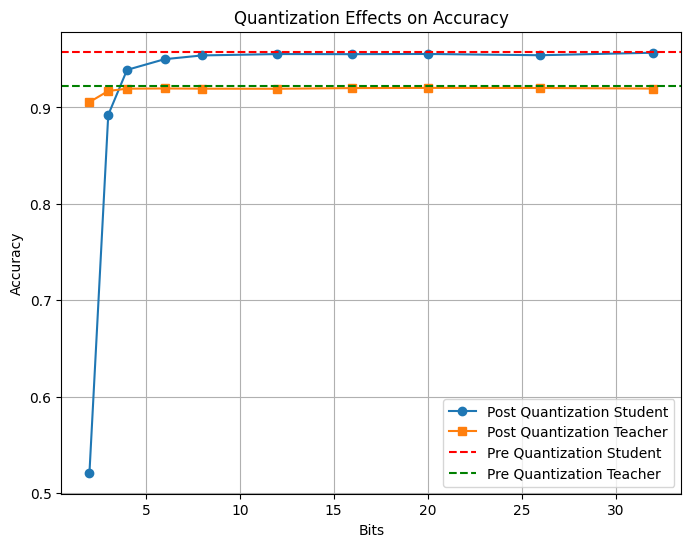

In [13]:
import matplotlib.pyplot as plt

# Data extracted from the image
bits = [2, 3, 4, 6, 8, 12, 16, 20, 26, 32]
post_quantization_r50 = post_quantization
pre_quantization_r50 = pre_quantization
#post_quantization_r50 = [0.521, 0.8923, 0.939, 0.9501, 0.954, 0.9533, 0.9523, 0.9539, 0.9518, 0.9519]
#pre_quantization_r50 = 0.9577  # A single value, likely a reference line
#post_quantization_teacher = [0.9067, 0.9092, 0.9108, 0.9114, 0.9118, 0.9097, 0.9124, 0.9132, 0.9108, 0.9118]
#pre_quantization_teacher = 0.9224  # A single value, likely a reference line

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(bits, post_quantization_r50, marker='o', label='Post Quantization Student')
plt.plot(bits, post_quantization_teacher, marker='s', label='Post Quantization Teacher')
plt.axhline(pre_quantization_r50, color='r', linestyle='--', label='Pre Quantization Student')
plt.axhline(pre_quantization_teacher, color='g', linestyle='--', label='Pre Quantization Teacher')

# Labels and legend
plt.xlabel('Bits')
plt.ylabel('Accuracy')
plt.title('Quantization Effects on Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('../images/resnet50.png', dpi=500)

In [ ]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(student_model)

In [ ]:
from quantize_neural_net import QuantizeNeuralNet


In [ ]:
quantized_model = quantizer.quantize_network()

In [20]:
import detectors
import timm

model = timm.create_model("resnet50_cifar100", pretrained=True)


In [24]:
train_val_loader, train_loader, val_loader, test_loader = utilities.data_utils.load_data_CIFAR100()


Files already downloaded and verified
Files already downloaded and verified


In [25]:
model.to(fast_device)
_, test_test_acc = utilities.utils.getLossAccuracyOnDataset(model, test_loader, fast_device)

In [26]:
print(test_test_acc)

0.7643
